<a href="https://colab.research.google.com/github/yeaeunJi/deep_learning-/blob/main/%EC%9E%90%EC%97%B0%EC%96%B4%EC%99%80_%EB%8B%A8%EC%96%B4%EC%9D%98_%EB%B6%84%EC%82%B0%ED%91%9C%ED%98%84.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 파이썬으로 말뭉치 처리(corpus)
- 간단한 전처리(preprocessing) ==> 텍스트 데이터를 단어로 분할하고, 분할된 단어들을 단어 id 리스트로 변환

In [8]:
text = 'You say goodbye and I say hello.'
text = text.lower() # 모든 문자를 소문화 변환
text = text.replace('.', ' .') # 문장의 단위를 끊는 '.'를 공백이 포함된 ' .'로 대체

print(text)

# 단어 추출
words = text.split(' ') #
print(words)


# 단어 분할을 위해 마침표 앞에 공백을 넣는 것 이외에 정규표현식(regular expression)을 이용하면 더 범용적임
# import re
# words = re.split('(\W+)?',text)
# print(words)

you say goodbye and i say hello .
['you', 'say', 'goodbye', 'and', 'i', 'say', 'hello', '.']


In [10]:
# 단어에 id를 부여하여, 단어와 단어 id별 대응되도록 파이썬의 dict 객체 생성
word_to_id = {}
id_to_word= {}

for word in words :
  if word not in word_to_id : # 단어 리스트에 없는 단어일 경우 추가
    new_id = len(word_to_id)
    word_to_id[word] = new_id
    id_to_word[new_id] = word

print('key : id, value : word인 dict', id_to_word)
print('key : word, value : id인 dict', word_to_id)

# 단어로 단어 id를 검색하거나 반대의 경우도 검색 가능해짐

key : id, value : word인 dict {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '.'}
key : word, value : id인 dict {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '.': 6}


In [11]:
# 단어 목록을 단어 id 목록으로 변경
import numpy as np

corpus = [ word_to_id[w] for w in words]
corpus = np.array(corpus)
print(corpus)

[0 1 2 3 4 1 5 6]


In [12]:
# 구현한 함수를 모아서 preprocess() 함수로 구현
def preprocess(text) :
  # 입력받은 text 데이터에서 공백을 기준으로 단어 추출
  text = text.lower()
  text = text.replace('.', ' .')
  words = text.split(' ')
  
  word_to_id = {}
  id_to_word = {}

  for word in words : 
    if word not in word_to_id :
      new_id = len(word_to_id)
      word_to_id[word] = new_id
      id_to_word[new_id] = word
    
  corpus = np.array([word_to_id[w] for w in words])

  return corpus, word_to_id, id_to_word

 

In [13]:
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus, word_to_id, id_to_word)

[0 1 2 3 4 1 5 6 7] {'you': 0, 'say': 1, 'goodbye': 2, 'and': 3, 'i': 4, 'hello': 5, '': 6, '.': 7} {0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello', 6: '', 7: '.'}


### 단어의 분산 표현
- 단어의 분산 표현('distributional representation) 
  - 텍스트인 단어를 '단어의 의미'를 정확하게 표현할 수 있는 벡터로 표현
  - 단어를 고정 길이의 밀집 벡터로 표현(대부분이 0이 아닌 실수인 벡터)

### 분포 가설
- '단어의 의미는 주변 단어에 의해 형성된다'라는 가설

- 자연어 처리에서 단어를 벡터로 표현하는 연구들은 '분포 가설(distributional hypothesis)'에서 착안됨

- 단어 자체에는 의미가 없고, 그 단어가 사용된 맥락(context)가 의미를 형성한다고 봄
  - 의미가 같은 단어들은 같은 맥락에서 더 자주 등장하며, 같은 맥락에서 사용되면 가까운 의미의 단어라는 것을 알 수 있음

    예) I drink beer //  I drink wine // We guzzle beer // We guzzle wine
    
    drink : 마시다, guzzle : 폭음하다

  - 맥락 : 주목하려는 단어의 주변에 높인 단어를 의미
  - 윈도우 크기(window size) : 주변 단어를 몇개나 포함할지를 의미
    
    예) 윈도우 크기 = 2이면, 좌우 두 단어씩이 맥락에 포함됨(총 4단어)



### 동시발생 행렬(co-occurrence matrix)
- 분포 가설을 기반으로 단어를 벡터로 나타내는 방법으로 '통계기반(statistical based) 기법'이 있음
  - 주목한 단어의 주변에 어떤 단어가 몇 번 등장하는지(빈도)를 집계하는 방법
  - 모든 단어 각각의 맥락에 해당하는 단어의 빈도

  - 이를 활용하여 단어를 벡터로 표현 가능

In [24]:
# corpus에서 동시발생 행렬을 생성해주는 함수
def create_co_matrix(corpus, vocab_size, window_size=1) :
  corpus_size = len(corpus)
  co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32) # 0으로 채워진 2차원 배열

  for idx, word_id in enumerate(corpus) :
    for i in range(1, window_size+1) :
      left_idx = idx - i
      right_idx = idx + i

      if left_idx >= 0 :
        left_word_id = corpus[left_idx]
        co_matrix[word_id, left_word_id] += 1

      if right_idx < corpus_size : 
        right_word_id = corpus[right_idx]
        co_matrix[word_id, right_word_id] += 1

  return co_matrix

### 벡터 간 유사도
- 동시발생 행렬을 활용하여 단어를 벡터로 표현한 후 이 벡터 사이의 유사도를 측정하는 방법이 필요

- 벡터 간 유사도를 측정하는 방법에는 대표적으로 벡터의 내적이나 유클리드 거리 등 있지만, 단어 벡터의 유사도를 나타낼 때에는 '코사인 유사도(cosine similarity)'를 자주 사용

  - 노름(norm) : 벡터의 크기
  - 코사인 유사도에서는  L2 노름으로 계산(벡터의 각 원소를 제곱하여 더한 후의 제곱근)
  - 벡터를 정규화하고 내적을 구하는 것이 코사인 유사도의 핵심(?)
  - 코사인 유사도를 '두 벡터가 가리키는 방향이 얼마나 비슷한가'를 살펴본다고 생각할 수 있으며, 두 벡터의 방향이 완전히 같으면 1, 완전히 반대면 -1

In [14]:
def cos_similarity(x,y) :
  nx = x / np.sqrt(np.sum(x**2)) # x의 정규화
  ny = y / np.sqrt(np.sum(y**2)) # y의 정규화
  return np.dot(nx, ny)

# 위의 함수는 원소가 모두 0인 벡터가 입력값이 될 경우 'divide by zero' 오류 발생
# 해결 : 분모에 작은 값을 더함
# 0.00000001과 같이 작은 값이면 부동소수점 계산 시 '반올림'되어 다른 값에 흡수되어
# 일반적으로 최종 계산 결과에 영향을 주지 않음
def cos_similarity(x,y, eps = 1e-8) :
  nx = x / (np.sqrt(np.sum(x**2)) + eps) # x의 정규화
  ny = y / (np.sqrt(np.sum(y**2)) + eps) # y의 정규화
  return np.dot(nx, ny)


In [25]:
# 'you'와 'i'의 유사도 구하기
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)

c0 = C[word_to_id['you']] # 'you'의 단어 벡터
c1 = C[word_to_id['i']] # 'i'의 단어 벡터
print(cos_similarity(c0, c1)) # 0.7071067691154799 ==> -1에서 1 사이므로, 유사성이 크다고 말할 수 있음

0.7071067691154799


### 유사 단어의 랭킹 표시하기
- 어떤 단어 검색 시 그 검색어와 비슷한 단어를 유사도 순으로 출력하는 함수

In [35]:
def most_similarity(query, word_to_id, id_to_word, word_matrix, top=5) :
  # 검색어 꺼내기
  if query not in word_to_id :
    print('%s(을)를 찾을 수 없습니다.' % query)
    return

  print('\n[query]' + query) 
  query_id = word_to_id[query]
  query_vec = word_matrix[query_id] 

   # 코사인 유사도 계산
  vocab_size = len(id_to_word)
  similarity = np.zeros(vocab_size)
  
  for i in range(vocab_size) :
    similarity[i] = cos_similarity(word_matrix[i], query_vec)

  # 코사인 유사도 기준 내림차순 출력
  count = 0

  for i in (-1 * similarity).argsort() :
    if id_to_word[i] == query :
      continue
    print('%s:%s' % (id_to_word[i], similarity[i]))

    count += 1
    
    if count >= top :
      return

In [36]:

# 'you'로 검색
most_similarity('you', word_to_id, id_to_word, C, top=5)


[query]you
goodbye:0.7071067691154799
i:0.7071067691154799
hello:0.7071067691154799
say:0.0
and:0.0


## 통계 기반 기법 개선
- 동시발생 행렬의 원소는 두 단어가 동시에 발생한 횟수를 나타내는데, 단순히 '발생 횟수'를 보는 것은 좋지 않음
  - 'the'와 'car'은 'car'과 'drive'보다 동시 발생 횟수가 많지만 후자가 더 관련이 깊음
  - 이와 같이 고빈도 단어가 강한 관련성을 갖는다고 평가될 수 있음

- 이러한 문제를 해결하기 위해 '점별 상호정보량(pointwise mutual information, PMI)라는 척도를 활용함
  - 단어가 단독으로 출현한 횟수를 고려하여, 고빈도 단어일 경우 PMI 점수가 낮아짐

- PMI의 문제점 : 두 단어의 동시 발생 횟수가 0일 경우, PMI의 값이 음의 무한대가 됨

- 양의 상호정보량(positive PMI, PPMI)  : PMI가 음수일 경우, 0을 취함
  - 문제점 : 말뭉치의 어휘 수가 증가하면 단어 벡터의 차원수도 증가하고, 대부분이 0인 희소행렬임. 이는 각 원소의 중요도가 낮다는 뜻이고, 이러한 벡터는 노이즈에 약하고 견고하지 못함.
  - 이러한 문제를 해결하기 위해 자주 수행하는 기법 ==> '벡터의 차원 감소'

In [41]:
# C  = 동시발생행렬
# verbose = 진행상황 출력 여부 플래그
def ppmi(C, verbose=False, eps=1e-8) :
  M = np.zeros_like(C, dtype=np.float32)
  N = np.sum(C) # 전체 단어 발생 횟수
  S = np.sum(C, axis=0) # 각 단어의 발생 횟수
  total = C.shape[0] * C.shape[1]
  cnt = 0

  for i in range(C.shape[0]) :
    for j in range(C.shape[1]) :
      pmi = np.log2(C[i,j] * N / (S[j]*S[i]) + eps)
      M[i,j] = max(0, pmi)
      
      if verbose :
        cnt += 1
        if cnt % (total/100) == 0:
          print('%.1f%% 완료' % (100*cnt/total))
  return M

In [42]:
text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

np.set_printoptions(precision=3) # 유효 자릿수를 세자리로 표시
print('동시발생 행렬')
print(C)
print('-'*50)
print('PPMI')
print(W)

동시발생 행렬
[[0 1 0 0 0 0 0]
 [1 0 1 0 1 1 0]
 [0 1 0 1 0 0 0]
 [0 0 1 0 1 0 0]
 [0 1 0 1 0 0 0]
 [0 1 0 0 0 0 1]
 [0 0 0 0 0 1 0]]
--------------------------------------------------
PPMI
[[0.    1.807 0.    0.    0.    0.    0.   ]
 [1.807 0.    0.807 0.    0.807 0.807 0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.    1.807 0.    1.807 0.    0.   ]
 [0.    0.807 0.    1.807 0.    0.    0.   ]
 [0.    0.807 0.    0.    0.    0.    2.807]
 [0.    0.    0.    0.    0.    2.807 0.   ]]


### 차원 감소(dimensionality reduction) 
- 벡터의 차원을 줄이는 되 '중요한 정보'를 최대한 유지하면서 줄이는 기법
- 데이터의 분포를 고려해 중요한 '축'을 찾는 일을 수행함(데이터를 넓게 분포시키는 축)
  - 각 데이터의 값은 새로운 축으로 사영된 값으로 변환되며 1차원 값만으로도 데이터의 본질적인 차이를 구별할 수 있어야 함

- 희소행렬(sparse matrix), 희소벡터(sparse vector) : 원소 대부분이 0인 행렬 또는 벡터를 의미.

- 차원 감소의 핵심 
  - 희소벡터에서 중요한 축을 찾아 더 적은 차원으로 다시 표현하여, 그 결과로 희소 벡터는 원소 대부분이 0이 아닌 값으로 구성된 밀집벡터로 변환됨. 이 조밀한 벡터가 우리가 원하던 단어의 분산 표현임

#### 차원 감소 방법
- 특잇값분해(Singular Value Decomposition, SVD)
  - 임의의 행렬을 세 행렬의 곱으로 분해
  - 행렬의 크기가 N이면 SVD 계산은 O(N**3)이 걸림. 따라서 Truncated SVD와 같이 특잇값이 작은 값은 버리는 방식으로 성능 향상을 함

- 단어의 벡터 공간에서는 의미가 가아운 단어는 그 거리도 가까울 것으로 기대

[0 1 0 0 0 0 0]
[0.    1.807 0.    0.    0.    0.    0.   ]
[ 3.409e-01  0.000e+00 -1.205e-01 -3.886e-16 -9.323e-01 -1.110e-16
 -2.426e-17]
[0.341 0.   ]


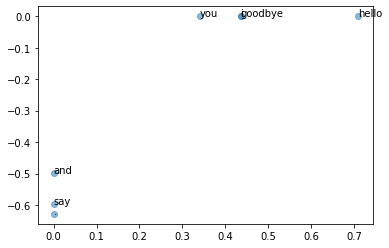

In [46]:
# SVD는 넘파이의 linalg(선형대수의 약어) 모듈이 제공하는 svd 메소드로 실행 가능
import numpy as np
import matplotlib.pyplot as plt

text = 'You say goodbye and I say hello.'
corpus, word_to_id, id_to_word = preprocess(text)
vocab_size = len(word_to_id)
C = create_co_matrix(corpus, vocab_size)
W = ppmi(C)

# SVD
U, S, V = np.linalg.svd(W) # 변수 U에 SVD에 의해 변환된 밀집벡터 표현이 저장됨

# 단어 id가 0인 단어 벡터
print(C[0]) # 동시발생 행렬
print(W[0]) # PPMI 행렬
print(U[0]) # SVD

# 이렇게 변환된 밀집벡터의 차원을 감소시키려면 n개의 원소를 꺼내면 됨
# 예 ) 2차원 벡터로 차원 축소
print(U[0, :2])

for word, word_id in word_to_id.items() :
  plt.annotate(word, (U[word_id, 0], U[word_id, 1]))

plt.scatter(U[:,0], U[:,1], alpha=0.5)
plt.show()

### PTB 데이터셋
- 펜 트리뱅그(Penn Trebank)

- word2vec 발명자인 토마스 마콜로프의 웹페이지에서 받은 PTB 말뭉치 사용
  - PTB 말뭉치에서는 한 문장이 하나의 줄로 저장되어 있고, 각 문장을 연결한 '하나의 큰 시계열 데이터'로 취급
  - 희소한 단어는 <unk>라는 특수 문자로 치환, 구체적인 숫자는 N으로 대체되어 있음
  - 각 문장 긑에 <eos>라는 특수 문자 삽입

In [48]:
# 데이터 셋은 생략하고 코드만 따라쳤음
# 큰 행렬에 SVD를 적용해야 하므로 고속 SVD를 이용해야 함
# 그러기 위해서는 sklearn 모듈을 설치해야 함

# try :
#   # trncated SVD
#   from sklearn.utils.extmath import randomized_svd
#   U, S, V = randomized_svd(W, n_components=wordvec_size, n_iter=5, random_state=None)

# except ImportError:
#   # SVD(느리고 메모리 소모가 큼)
#   U, S, V = np.linalg.svd(W)